# Constructing a Pore Network Model using Parameter Estimates of Throat and Pore Size Distributions

CHE 499 Elective Research Project - Fall 2021

Submitted By: Jihye Oh (20669869)

## Table of Contents
**Introduction**

**1. Prepare the Necessary Packages and Data**

&emsp;**1.1.** Import the Required Packages

&emsp;**1.2.** Extract Throat Sizes from the Image

**2. Fit the Distributions**

&emsp;**2.1.** Fit a Continuous Distribution to the Throat and Pore Size Distributions

&emsp;**2.2.** Evaluate the "Goodness of Fit"

**3. Construct the Pore Network Model**

&emsp;**3.1.** Emulate the Throat and Pore Size Distributions

&emsp;**3.2.** Compare the Observed and Simulated Distributions

**4. Evaluate the Pore Space Characterization**

&emsp;**4.1.** Calculate the Permeability Coefficient

&emsp;**4.2.** Compare Porosimetry Curves

**References**

**Supplementary File:** `psd_tsd_tools.py`

***

## Introduction
Pore spaces must be characterized in order to study the processes that occur within porous media. If accurately characterized, pore network models provide a way to predict the paths the fluid would take. This report presents one way in which a pore network model can be constructed using continuous distribution fitting onto throat and pore size distributions. The throat and pore diameter data are fitted to a continuous distribution, such as lognormal, gamma, or Weibull, using a non-linear least squares method. This returns the parameters of the fitted function. The “goodness of fit” is judged by visual inspection, as seen in Section 2.2 below. The accuracy of these parameters is a critical component to this method because the pore network model is built upon these parameters that characterize the observed throat and pore size distributions. Again, using visual inspection, the throat and pore size distributions from the original pore space can be compared with those from the constructed representation. 

Once the pore network model is constructed, it can be evaluated in two ways: the permeability coefficient, and mercury intrusion porosimetry (MIP). The permeability coefficient can be compared to the value expected by heuristic. MIP is an experimental technique commonly performed for pore space characterization, which produces a plot for fraction of void space filled as a function of capillary pressure [1]. Similarity in the shapes of the two porosimetry curves would indicate that the pore network model represents the experimentally characterized pore space with accuracy. 


## 1. Prepare the Necessary Packages and Data
### 1.1. Import the Required Packages
`psd_tsd_tools.py` is the accompanying Python script containing the following functions:
* `parse_histogram`: manipulates input dataset to produce histogram data (i.e. bins)
* `dist_curvefit`: determines the shape, size, and loc parameters of the fitted continuous distribution
* `generate_pn`: recreates the pore size distribution using the shape, scale, and location parameters determined from the image
* `generate_tn`: recreates the throat size distribution using the shape, scale, and location parameters determined from the image
* `switch_throat`: rearranges or reduces the size of throats to ensure that all throat sizes are smaller than its neighboring pore sizes

In [41]:
import openpnm as op
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import imageio
import porespy as ps
from skimage.morphology import skeletonize_3d, cube, square
from skimage.segmentation import watershed, find_boundaries
import scipy.ndimage as spim
from edt import edt
from psd_tsd_tools import *

### 1.2. Extract Throat Sizes from the Image
The image used in this example is of Bentheimer sandstone and was obtained from [DigitalRocksPortal.org](https://www.digitalrocksportal.org/projects/223/origin_data/878/). The voxel length provided by the author is 8.9 micron. The image is converted from grey-scale to binary, using 200 as the threshold. The throats are shown as blue lines in the image below, where the throat size data is stored in `throatsizes`.

*Note: This section of code was provided by Dr. Gostick.*

  0%|          | 0/25 [00:00<?, ?it/s]

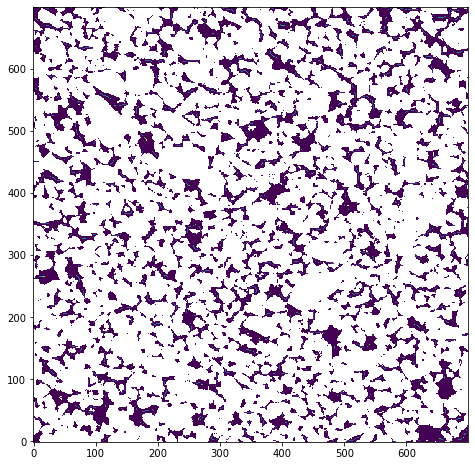

In [16]:
im = mpimg.imread('frame_006_delay-0.14s.jpg') < 200
lt = ps.filters.local_thickness(im)
dt = edt(im)
sk = skeletonize_3d(im) > 0 
conv = spim.convolve(sk*1.0, square(3))
pt = (conv >= 4)*sk
pt += (conv == 2)*sk
pt = ps.filters.reduce_peaks(pt)
c = np.vstack(np.where(pt)).T
Ps = np.zeros_like(sk, dtype=bool)
for n, (i, j) in enumerate(c):
    ps.tools.insert_sphere(im=Ps, c=np.hstack((i, j)), r=dt[i, j]/1., v=True, overwrite=False)
Ts = sk*(~Ps)
ws = ps.filters.snow_partitioning(Ps, sigma=1).regions * Ps
ws = ps.tools.randomize_colors(ws)
fig, ax = plt.subplots(1, 1, figsize=[8, 8])
ax.imshow(Ts*dt/im, origin='lower', interpolation='none')
labels, N = spim.label(Ts, structure=square(3))
throatsizes = []
for i in range(1, N):
    temp = labels == i
    throatsizes.append(dt[temp].min())

## 2. Fit the Distributions 
### 2.1. Fit a Continuous Distribution to the Throat and Pore Size Distributions
The key objective of this section is to obtain the shape (if applicable), scale, and location parameters of the fitted Weibull distribution. Data from `throatsizes` is arranged into a histogram and defined as `tsd`. The pore size distribution, `psd`, of the image is obtained using PoreSpy's local thickness filter, followed by `pore_size_distribution`. The distributions are fitted using the `dist_curvefit` function from the supplementary python script `psd_tsd_tools.py`. 

There are a number of continuous distributions from `scipy.stats` available for fitting, such as lognormal, gamma, and normal distributions. In this case, the Weibull distribution is selected. The cumulative distribution function (cdf) of the Weibull distribution is expected to produce a good fit for the curves. 

In [49]:
from scipy.stats import lognorm, gamma, weibull_min, norm, weibull_max
voxel_size = 8.9e-6 #[m]
dist = weibull_min
H = np.histogram(np.asarray(throatsizes)*voxel_size,density=True)
tsd = parse_histogram(H,voxel_size=1)
thk = ps.filters.local_thickness(im, mode='dt')
psd = ps.metrics.pore_size_distribution(im=thk, bins=20,log=False,voxel_size=voxel_size)
t = dist_curvefit(dist,tsd,voxel_size)
p = dist_curvefit(dist,psd,voxel_size)

  0%|          | 0/25 [00:00<?, ?it/s]

### 2.2. Evaluate the "Goodness of Fit"
The throat and pore size distributions obtained from the image are compared to their respective fitted Weibull distribution. The bars are the data observed in the image, while the yellow and red lines are the fitted curves, with each of their parameters shown in the legend. 'C', 'n', and 'l' are shape, scale, and location parameters, respectively. For both distributions, we see that the cumulative distribution function of the Weibull distribution follows the data closely, as we expected.

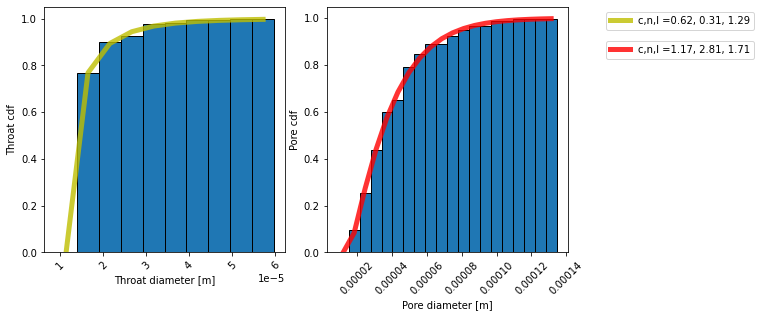

In [18]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
plt.tight_layout()

ax1.set_xlabel('Throat diameter [m]')
ax1.set_ylabel('Throat cdf')
ax1.bar(tsd.bin_centers, t.cdf, width=tsd.bin_widths[0], edgecolor='k')
ax1.plot(tsd.bin_centers, t.fit,'y-', lw=5, alpha=0.8, 
         label='c,n,l ='+str(round(t.param[0],2))+', '+str(round(t.param[1],2))+', '+str(round(t.param[2],2)))
handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, bbox_to_anchor=(1.3, 0.9),loc='right')
ax1.tick_params('x',labelrotation=45)

ax2.set_xlabel('Pore diameter [m]')
ax2.set_ylabel('Pore cdf')
ax2.bar(psd.bin_centers, p.cdf, width=psd.bin_widths[0], edgecolor='k')
ax2.plot(psd.bin_centers, p.fit,'r-', lw=5, alpha=0.8,
         label='c,n,l ='+str(round(p.param[0],2))+', '+str(round(p.param[1],2))+', '+str(round(p.param[2],2)))
handles, labels2 = ax2.get_legend_handles_labels()
fig.legend(handles, labels2, bbox_to_anchor=(1.3, 0.8),loc='right')
ax2.tick_params('x',labelrotation=45)

## 3. Construct the Pore Network Model
### 3.1. Emulate the Throat and Pore Size Distributions
The throat and pore size distributions are recreated for a cubic pore network using the distribution parameters obtained by curve fitting. As a design choice, the geometry of the pore network is selected to be *ConesAndCylinders*. Other design choices are the cubic network shape (i.e. 20 by 20 by 20) and pore spacing, which is taken to be 1.5 times the maximum pore diameter from the image.

Prior to generating the pore network, any pre-existing data for pore and throat sizes are deleted. The simulated pore and throat size distributions for the network are represented by `pn` and `tn`, generated by `generate_pn` and `generate_tn`, respectively. Then, the throat size distribution is manipulated to ensure that all throat sizes are smaller than its neighbouring pores. See the `switch_throat()` docstring for more information on how this is done.

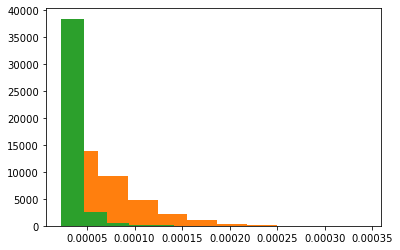

In [31]:
Lx = 20
Ly = 20
Lz = 20
S = 1.5*max(psd.bin_centers)

net = op.network.Cubic(shape=[Lx, Ly, Lz],spacing=S) 
geo = op.geometry.SpheresAndCylinders(network=net, pores=net.Ps, throats=net.Ts) 
del geo.models['pore.diameter'],geo.models['throat.diameter'],geo.models['pore.seed']

pn, geo = generate_pn(net,geo,dist,p.param,voxel_size)
tn, geo = generate_tn(net,geo,dist,t.param,voxel_size)
model = op.models.misc.from_neighbor_pores
geo['throat.maxsize'] = model(target=geo, prop='pore.diameter', mode='min')
geo = switch_throat(geo)
geo.regenerate_models()

### 3.2. Compare the Observed and Simulated Distributions
The probability density functions of the observed distributions (left) and simulated distributions (right) are plotted. We see clear similarities in the shape of the throat size distributions. The pore size distributions are less precise in shape, but the bin width for the simulation is noticeably larger. It may be worth examining how to generate a pore size distribution with equal bin width as the observed data. 

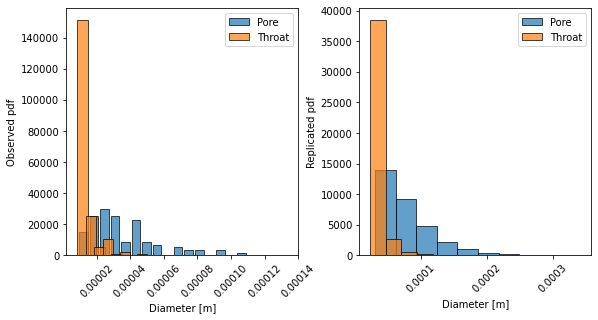

In [33]:
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2,figsize=(8, 4))
plt.tight_layout(pad=1, w_pad=3, h_pad=1.0)
ax1.set_xlabel('Diameter [m]')
ax1.set_ylabel('Observed pdf')
ax1.tick_params('x',labelrotation=45)
ax2.set_xlabel('Diameter [m]')
ax2.set_ylabel('Replicated pdf')
ax2.tick_params('x',labelrotation=45)

ax1.bar(psd.bin_centers,psd.pdf,width=tsd.bin_widths[0],alpha=0.7,edgecolor='k',label='Pore')
ax1.bar(tsd.bin_centers,tsd.pdf,width=psd.bin_widths[0],alpha=0.7,edgecolor='k',label='Throat')
ax2.bar(pn.bins,pn.pdf,width=pn.binwidth,alpha=0.7,edgecolor='k',label='Pore')
ax2.bar(tn.bins,tn.pdf,width=tn.binwidth,alpha=0.7,edgecolor='k',label='Throat')

ax1.legend()
ax2.legend()

## 4. Evaluate the Pore Space Characterization
### 4.1. Calculate the Permeability Coefficient
Using air as the fluid and Stokes Flow as the mode of flow, air enters the pore network from the left. The OpenPNM algorithm is run and the permeability coefficient is calculated by Darcy's Law:

$ Q = \frac{K A}{\mu L}  \Delta P $

where 
* Q is the flowrate of air entering the pore network $[m^{3}/s]$
* K is the permeability coefficient $[m^{2}]$
* A is the cross-sectional area normal to the direction of flow $[m^{2}]$
* $\mu$ is the air viscoscity $[Ns/m^{2}]$
* L is the length of the pore network in the direction of flow $[m]$
* $\Delta P$ is the pressure drop across the pore network $[Pa]$, taken as 1 Pa (i.e. negligible pressure drop).

This produces a permeability coefficient (shown below) value sufficiently close to the expected value. The expected value is $10^{-12} m^{2}$.

In [34]:
air = op.phase.Air(network=net)
phys = op.physics.Basic(network=net, geometry=geo, phase=air)
alg = op.algorithms.StokesFlow(network=net, phase=air)
alg.set_value_BC(pores=net.pores('left'), values=1)
alg.set_value_BC(pores=net.pores('right'), values=0)
alg.run()
K = alg.rate(pores=net.pores('left'))*air['pore.viscosity'][0]*(Lx*S)/(Ly*Lz*S**2)
print(K[0])

7.062699001509326e-13                                                 


### 4.2. Compare Porosimetry Curves
Mercury intrusion porosimetry (`mip`) is performed for the network in the image and the simulated pore network. The two curves show similar shape and both rise steeply at around $3*10^{4}$ Pa. This and the proximity of the permieability coefficient to the expected value indicate that the pore network model is an accurate representation of the pore space.

In [ ]:
im3D = imageio.volread('benheimer_Central_Cube_700.tif') < 200
mio = ps.filters.porosimetry(im=im3D)
e = ps.metrics.pc_curve_from_mio(im=im3D, sizes=mio,sigma=0.46, theta=140, stepped=False, voxel_size=voxel_size)

------------------------------------------------------------
SOURCE     : openpnm.algorithms._ordinary_percolation.get_intrusion_data 
TIME STAMP : 2022-01-03 10:38:12,975
------------------------------------------------------------


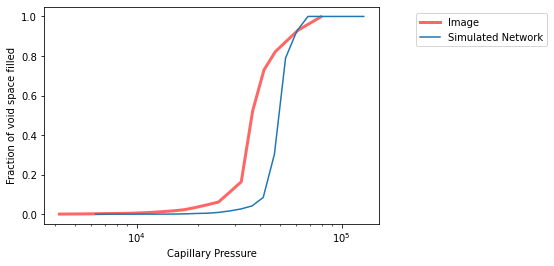

In [55]:
fig, ax = plt.subplots()
ax.set_xlabel('Capillary Pressure')
ax.set_ylabel('Fraction of void space filled')
ax.semilogx(np.array(e.pc), e.snwp, 'r-', markersize=20, linewidth=3, alpha=0.6, label='Image');
hg = op.phase.Mercury(network=net)
phys_hg = op.physics.Standard(network=net, phase=hg, geometry=geo)
mip = op.metrics.Porosimetry(network=net, phase=hg)
mip.set_inlets(pores=net.pores(['left', 'right']))
mip.run()
x, y = mip.get_intrusion_data()
ax.semilogx(x, y, label='Simulated Network')
fig.legend(bbox_to_anchor=(1.3, 0.8), loc='right');

#### References
[1] Xiong, Q., Baychev, T. G., &amp; Jivkov, A. P. (2016). Review of pore network modelling of Porous Media: Experimental Characterisations, network constructions and applications to reactive transport. Journal of Contaminant Hydrology, 192, 101–117. https://doi.org/10.1016/j.jconhyd.2016.07.002 